In [2]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from TCN_jordan import *

In [103]:
data_air_quality=pd.read_csv(r'Dataset/AirQualityUCI.csv',sep=';',decimal=',',na_values='-200')
data_air_quality

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module TCN_jordan not in sys.modules
]


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
data_set=data_air_quality[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'RH', 'AH']].astype('float32')

In [107]:
def calculate_nan_percentage(dataframe):
    # Count the number of NaN values in each column
    nan_counts = dataframe.isna().sum()

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_counts / len(dataframe)) * 100

    return nan_percentage.sort_values(ascending=False)
calculate_nan_percentage(data_set)

NMHC(GT)         90.349488
CO(GT)           18.973709
NO2(GT)          18.540809
NOx(GT)          18.509133
PT08.S1(CO)       5.068103
C6H6(GT)          5.068103
PT08.S2(NMHC)     5.068103
PT08.S3(NOx)      5.068103
PT08.S4(NO2)      5.068103
PT08.S5(O3)       5.068103
RH                5.068103
AH                5.068103
dtype: float64

In [114]:
nan_dataset=calculate_nan_percentage(data_set)

# data_set=data_set.drop(columns='NMHC(GT)')
data_set=data_set.drop(columns=list(nan_dataset[nan_dataset>40].index),axis=1) 
data_set= data_set.fillna(data_set.median())

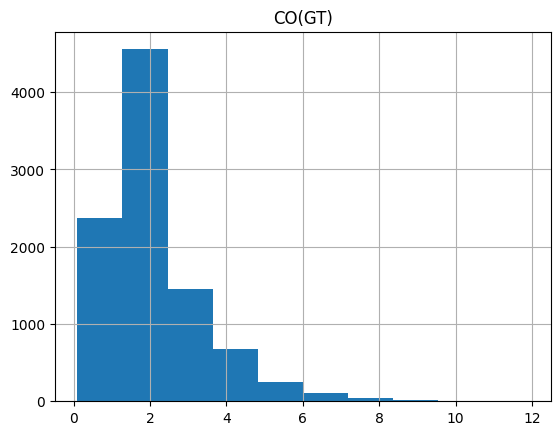

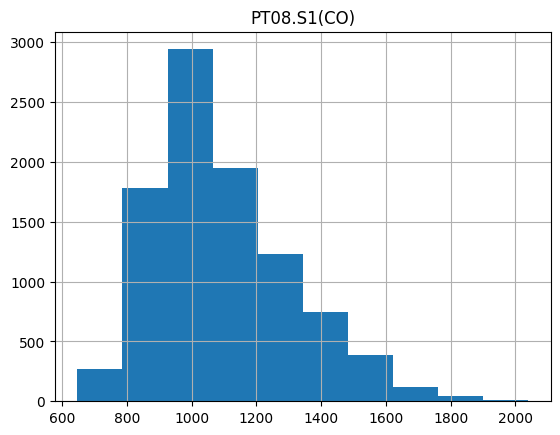

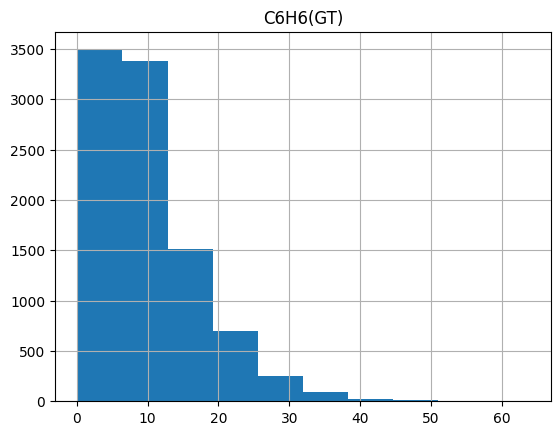

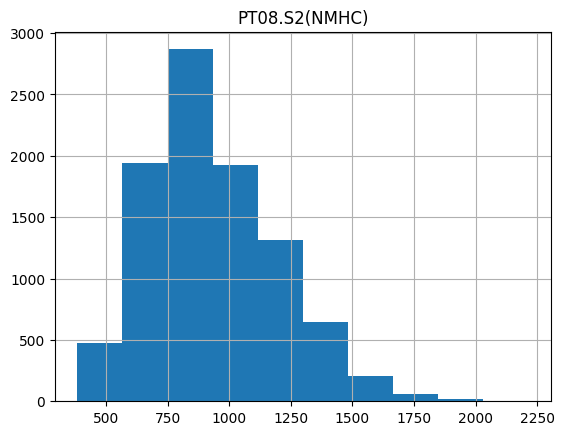

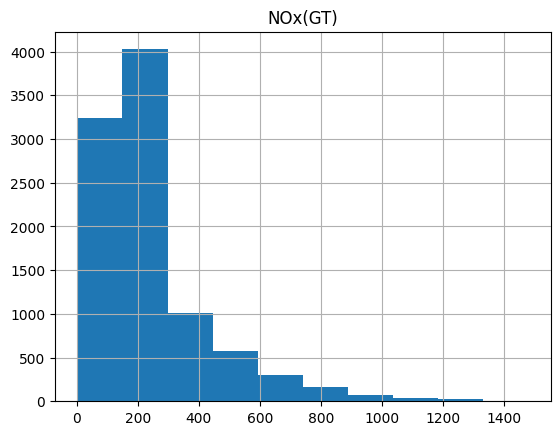

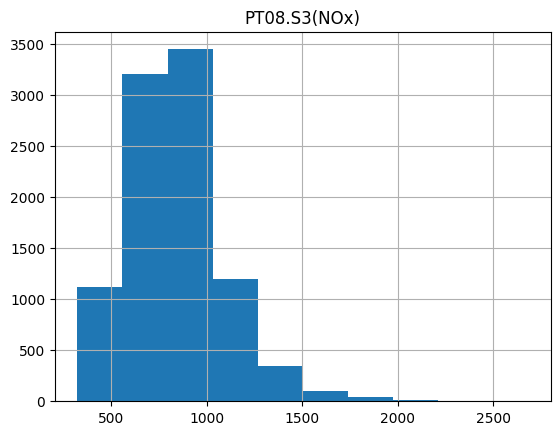

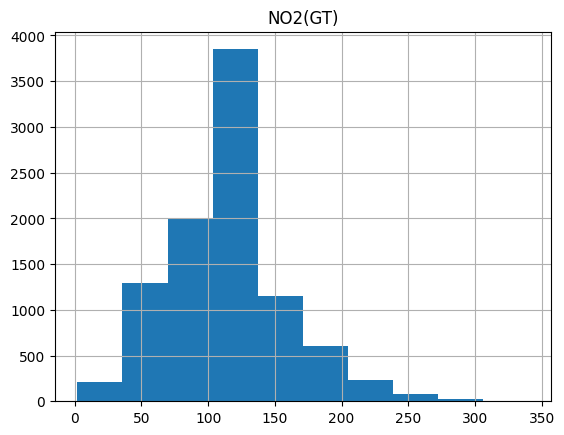

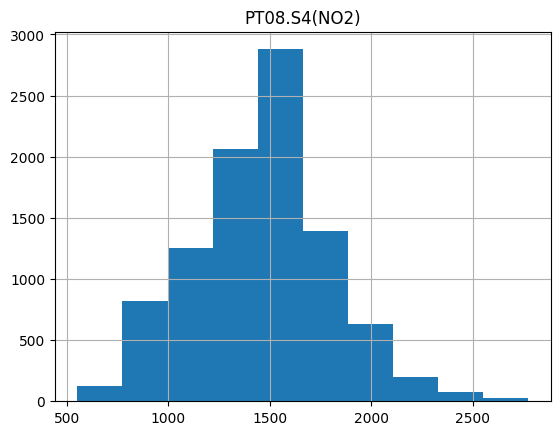

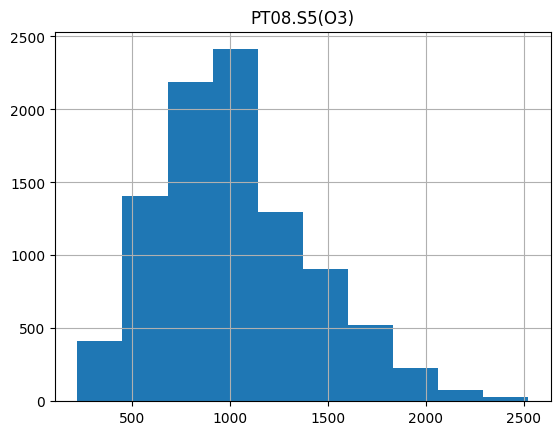

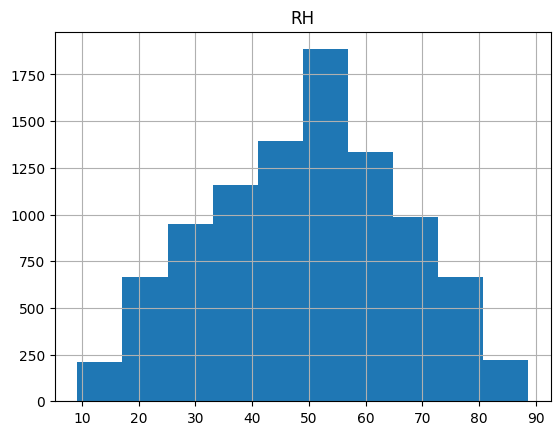

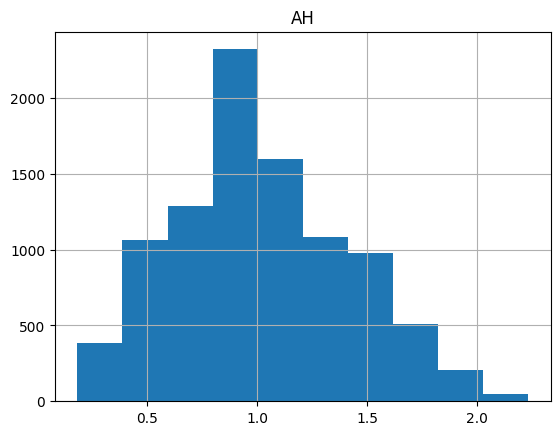

In [80]:
for col in data_set.columns:
        data_set[col].hist()
        plt.title(col)
        plt.show()

In [84]:
# standard scale the data
data_set=(data_set-data_set.mean())/data_set.std()

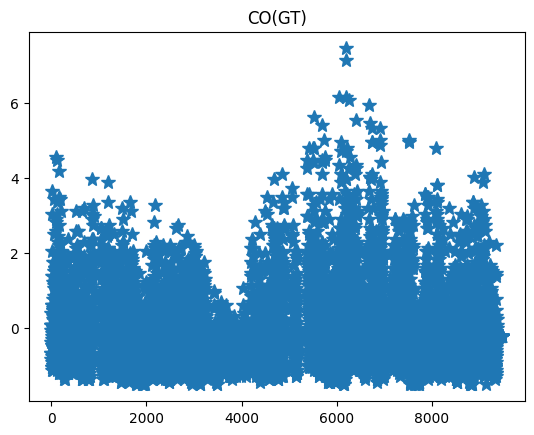

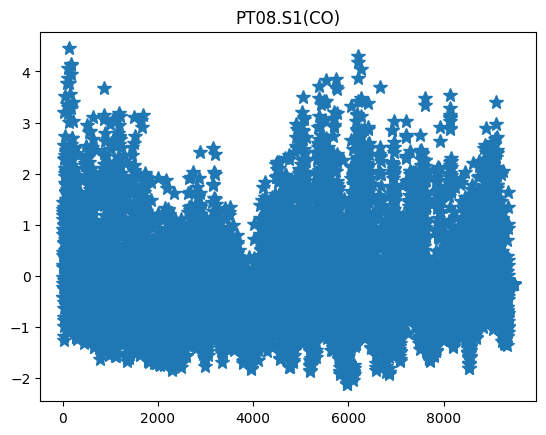

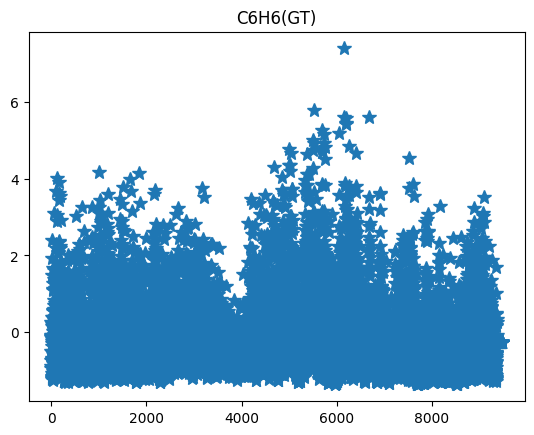

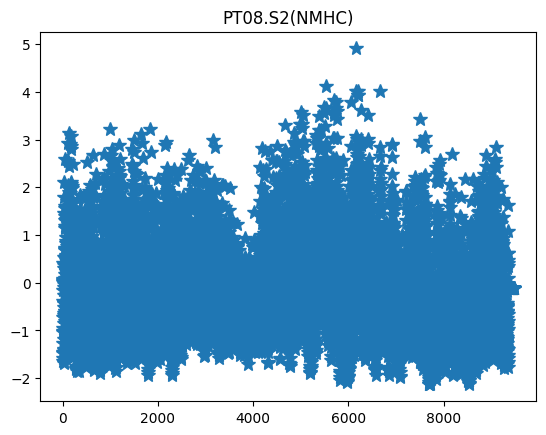

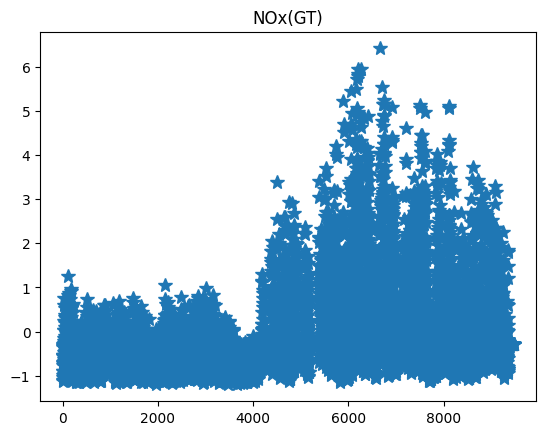

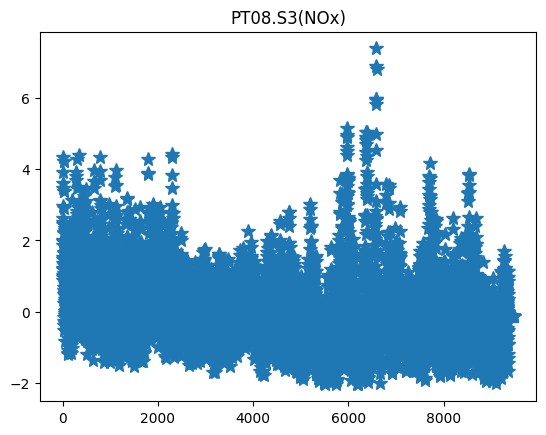

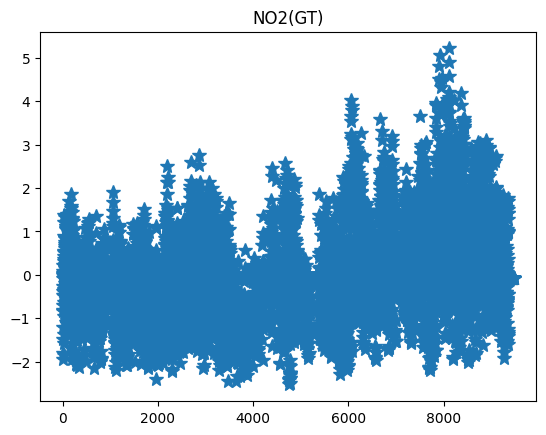

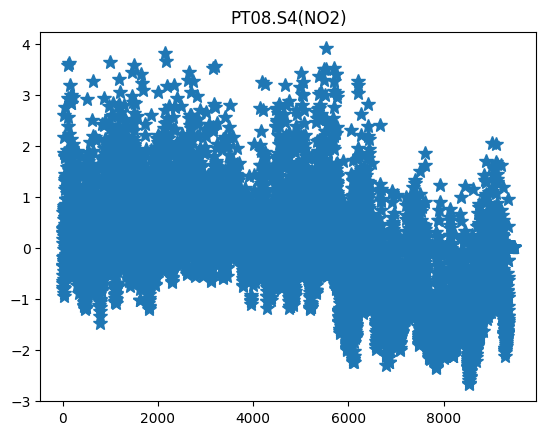

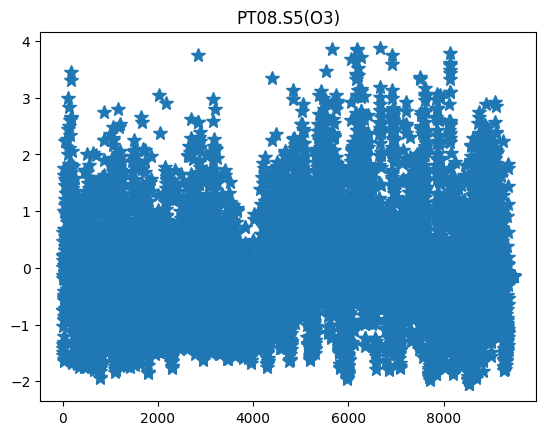

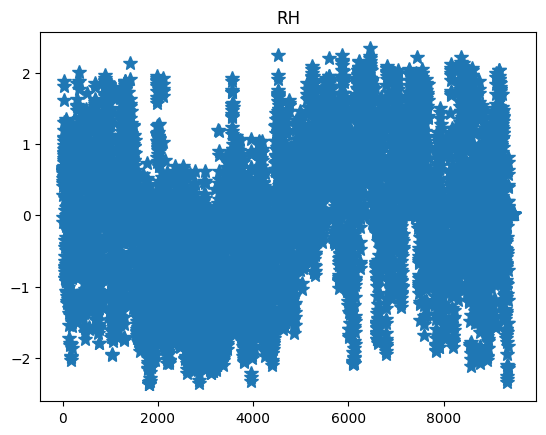

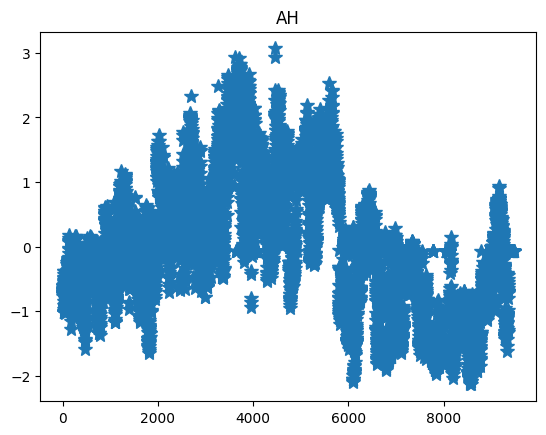

In [94]:
for col in data_set.columns:
        data_set[col].plot(marker='*', linestyle='', markersize=10)
        plt.title(col)
        plt.show()

In [96]:

# data_set = pd.read_csv(r'Dataset/exchange_rate.csv')
train_val_data = data_set[: int(0.95 * len(data_set))]

validation_data = train_val_data[int(0.8 * len(train_val_data)):].copy()
train_data = train_val_data[: int(0.8 * len(train_val_data))]

test_data = data_set[int(0.95 * len(data_set)):]

In [6]:
def objective(trial):

    try:

        # Instantiate your ElectricNet model with the sampled hyperparameters
        window_size = trial.suggest_int('window_size', 5, 30)
        kernel_size = 2*trial.suggest_int('kernel_size', 1, 5)+1
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
        n_hidden_dimensions = trial.suggest_int('n_hidden_dimensions', 1, 8)
        
        # n_signals = trial.suggest_int('n_signals', 1, 10)
        prediction_horizon = 3 #trial.suggest_int('prediction_horizon', 1, 2)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        batch_size = trial.suggest_int('batch_size', 16, 128)
        
        patience = 30 #trial.suggest_int('patience', 10, 30)
        conv_dilatation = 1 #trial.suggest_int('conv_dilatation', 1, 1) 
        
        # TODO : - Conv dilation il l'a enforcé à 1 - kernel size est obligé d'être impair à cause de comment il set le padding - les index à prendre ca doit etre dim_points_df-prediction_horizon+1 - revoir la relation windows size et training - check l'architecture
        
        
        nb_epochs = trial.suggest_int('nb_epochs', 50, 200)
    
        # Create an instance of the PSTA_TCN model with the sampled hyperparameters
        model = PSTA_TCN(
            window_size=window_size,
            kernel_size=kernel_size,
            n_hidden_layers=n_hidden_layers,
            n_hidden_dimensions=n_hidden_dimensions,
            n_signals=n_signals,
            prediction_horizon=prediction_horizon,
            lr=lr,
            dropout_rate=dropout_rate,
            batch_size=batch_size,
            nb_epochs=nb_epochs,
            patience=patience,
            conv_dilatation=conv_dilatation
        )        


        model.fit(train_data, validation_data)

        points=predict_fn(model,data_set)
        df_points=pd.DataFrame(points.detach().numpy())
        df_points[0]=df_points[0].astype('int')
        df_points= df_points.groupby(0).mean()
        


        return np.linalg.norm(data_set.iloc[df_points.index-2,0].values.flatten()-df_points.values.flatten())


    except Exception as e:
        raise optuna.exceptions.TrialPruned(f'Skipping this trial due to an error: {str(e)}')
    


In [7]:
def run_optuna():

    study = optuna.create_study()
    study.optimize(objective, n_trials=50)
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")

    study.trials_dataframe().to_excel(r'/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/result_summary.xlsx')
    fig = optuna.visualization.plot_param_importances(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_params.png", format='png', engine='kaleido')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_history.png", format='png', engine='kaleido')


    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_num=list(study.trials_dataframe().sort_values(by='value', ascending=False)[:5]['number'])
    print(best_num)


In [ ]:
run_optuna()

[I 2023-12-17 14:24:31,418] A new study created in memory with name: no-name-96ed6c31-b687-49b9-94b5-7958595a3e08
[I 2023-12-17 14:24:31,418] A new study created in memory with name: no-name-96ed6c31-b687-49b9-94b5-7958595a3e08
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:6: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:7: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:8: FutureWarning:

suggest_int(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_59948/4029309941.py:9: FutureWarning:

suggest_int

In [9]:
def predict_fn(model,dataset):
        prediction_horizon=model.tau
        window_size=model.T 
        train_set = torch.from_numpy(dataset.astype('float32').values)
        train_data = [train_set[i: i + window_size] for i in range(len(train_set) - window_size)]
        point_to_plot=[]
        for i,x in enumerate(train_data):
                predictions=model.predict(x)
                point_to_plot+=[torch.Tensor([v,predictions.squeeze()[k]]) for k,v in enumerate(np.arange(i+window_size,i+window_size+prediction_horizon))]
        
        point_to_plot=torch.stack(point_to_plot)
        
        return point_to_plot
  

In [98]:
model_2= PSTA_TCN(
window_size=25,
kernel_size=5,
n_hidden_layers=3,
n_hidden_dimensions=5,
n_signals=11,
prediction_horizon=2,
batch_size=82,
patience=25,
lr=9.177087709816208e-05,
nb_epochs=100,
number_TCN=3,
dropout_rate=0.05,
seed=55,
)


model_2.fit(train_data,validation_data)

In [101]:
points=predict_fn(model_2,test_data)

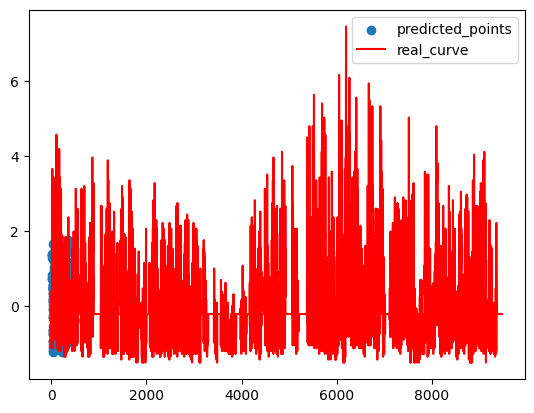

In [102]:
plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
data_set.iloc[:,0].plot(label='real_curve',color='red')
plt.legend()

In [ ]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)

In [165]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)
# df_points=pd.DataFrame(points.detach().numpy())
# df_points[0]=df_points[0].astype('int')
# df_points= df_points.groupby(0).mean()
# np.linalg.norm(data_set.iloc[df_points.index-1,0].values.flatten()-df_points.values.flatten())

7587